# Taiwan Commercial Bank Credit Default Analysis

## Business Understanding

Since it's inception in 2001 the Taiwan Commercial Bank as had its fair share of successes and shortcomings, among them credit card default by customers where a borrower fails to meet their repayment obligations. This hinders effective credit risk management which is essential to ensure financial stability, optimizing lending policies and enhancing customer experience. 

The bank aims to leverage machine learning and AI-driven classifications model to accurately assess the likelihood of a customer to default on credit card payments. This will improve the banks lending decision making to approve loans for reliable customers and adjusting credit limits based on a client's repayment behavior.

### __Problem Statement__

By leveraging historical client financial data with attributes such as past credit card bills and payments, credit card limit and level of education, the bank seeks to improve loan approval processes, minimize non-performing loans (NPLs), and optimize credit allocation strategies.
The goal is to build a classification model using past customer payment records, demographic details, and credit history to predict credit default (Yes = 1, No = 0).



### __Objectives__

#### __Classification task__
- Develop a model to classify customers as likely to default (1) or not (0)
- Identify key factors contributing to credit default risk.
- Enhance model performance through hyperparameter tuning and resampling techniques e.g. SMOTETomek
- Improve desicion making on credit card approvals and limit adjustment based on risk
- Optimize feature selection to use only the most relevant attributes for our predictions.

### __Data Description__

The data was obtained from the UCI machine learning repository [here](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients). It is a record from client's credit card records in Taiwan ranging from April to September 2005. This dataset contains 30000 rows and 23 columns of financial and demographic information of credit card clients, aiming to predict whether a client will default on their payment in the following month. The target variable (default payment) is binary:
    - 1 = Client defaulted on payment
    - 0 = Client did not default
    
__Features & Variables__<br>
__Demographic Features__

X2: Gender (1 = Male, 2 = Female)<br>
X3: Education Level (1 = Graduate, 2 = University, 3 = High School, 4 = Others)<br>
X4: Marital Status (1 = Married, 2 = Single, 3 = Others)<br>
X5: Age (in years)

__Credit Information__

X1: Amount of Given Credit (NT dollars)
Represents total credit limit, including supplementary cards.
Payment History (Past 6 Months)

X6 - X11: Monthly repayment status from April to September 2005
-1: Paid on time
1: Delay of 1 month, 2: Delay of 2 months, ..., 9: Delay of 9+ months
Billing Information (Past 6 Months)

X12 - X17: Monthly bill statement amount (NT dollars)
Represents outstanding credit card balance from April to September 2005
Payment History (Past 6 Months)

X18 - X23: Monthly payment amount (NT dollars)
Amount paid by the client from April to September 2005

## Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import statsmodels.api as sm
import warnings
from scipy.stats import uniform, loguniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, mean_squared_error, r2_score, roc_auc_score, log_loss
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#!pip install xlrd
#!pip install xgboost
#!pip install lightgbm
#!pip install optuna
warnings.filterwarnings('ignore')

In [2495]:
df = pd.read_excel('default+of+credit+card+clients/default of credit card clients.xls', skiprows =1)

In [2496]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [2497]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [2498]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [2499]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

## Data Cleaning

In [2501]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [2502]:
df = df.drop(columns = ['id'])

In [2503]:
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [2505]:
df.isna().sum()

limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt1                     0
bill_amt2                     0
bill_amt3                     0
bill_amt4                     0
bill_amt5                     0
bill_amt6                     0
pay_amt1                      0
pay_amt2                      0
pay_amt3                      0
pay_amt4                      0
pay_amt5                      0
pay_amt6                      0
default_payment_next_month    0
dtype: int64

In [2509]:
df.duplicated().sum()

35

In [2511]:
df = df.drop_duplicates()

In [2513]:
df.duplicated().sum()

0

In [2514]:
df.dtypes

limit_bal                     int64
sex                           int64
education                     int64
marriage                      int64
age                           int64
pay_0                         int64
pay_2                         int64
pay_3                         int64
pay_4                         int64
pay_5                         int64
pay_6                         int64
bill_amt1                     int64
bill_amt2                     int64
bill_amt3                     int64
bill_amt4                     int64
bill_amt5                     int64
bill_amt6                     int64
pay_amt1                      int64
pay_amt2                      int64
pay_amt3                      int64
pay_amt4                      int64
pay_amt5                      int64
pay_amt6                      int64
default_payment_next_month    int64
dtype: object

In [2515]:
education_mapping = {
    1: 1,  # Graduate School
    2: 2,  # University
    3: 3,  # High School
    4: 4,  # Others
    5: 4,  # Group into "Others"
    6: 4   # Group into "Others"
}

df['education'] = df['education'].map(education_mapping)

In [2516]:
df[['education']].isna().sum()

education    14
dtype: int64

In [2526]:
df['education'] = df['education'].fillna(4)

In [2528]:
df['education'].isna().sum()

0

In [2530]:
df['marriage'].unique()

array([1, 2, 3, 0], dtype=int64)

In [2532]:
marriage_mapping = {
    1: 1,  # Married
    2: 2,  # Single
    3: 3,  # Others
    0: 3,  # Grouping into others
}
df['marriage'] = df['marriage'].map(marriage_mapping)

### Feature Engineering

In [2535]:
df['totalbillamt'] = df[['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']].sum(axis=1)

In [2537]:
df['totalpayamt'] = df[['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']].sum(axis=1)

In [2539]:
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,totalbillamt,totalpayamt
0,20000,2,2.0,1,24,2,2,-1,-1,-2,...,0,0,689,0,0,0,0,1,7704,689
1,120000,2,2.0,2,26,-1,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,1,17077,5000
2,90000,2,2.0,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,101653,11018
3,50000,2,2.0,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,231334,8388
4,50000,1,2.0,1,57,-1,0,-1,0,0,...,19131,2000,36681,10000,9000,689,679,0,109339,59049


In [2541]:
# New column 'fullrepayment' where 1 means full repayment, 0 means not fully repaid
df['fullrepayment'] = (df['totalpayamt'] >= df['totalbillamt']).astype(int)
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,totalbillamt,totalpayamt,fullrepayment
0,20000,2,2.0,1,24,2,2,-1,-1,-2,...,0,689,0,0,0,0,1,7704,689,0
1,120000,2,2.0,2,26,-1,2,0,0,0,...,0,1000,1000,1000,0,2000,1,17077,5000,0
2,90000,2,2.0,2,34,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,101653,11018,0
3,50000,2,2.0,1,37,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,231334,8388,0
4,50000,1,2.0,1,57,-1,0,-1,0,0,...,2000,36681,10000,9000,689,679,0,109339,59049,0


In [2543]:
df['fullrepayment'].value_counts().unique()

array([25395,  4570], dtype=int64)

In [2545]:
df['default_payment_next_month'].value_counts().unique()

array([23335,  6630], dtype=int64)

In [2547]:
df['max_delay'] = df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].max(axis=1)

In [2549]:
# Binning max_delay into different levels of risk
bins = [-float('inf'), 1, 4, float('inf')]  # Bins: <=1, 2-4, 5+
labels = ['Low Risk', 'Medium Risk', 'High Risk']
df['risk_category'] = pd.cut(df['max_delay'], bins=bins, labels=labels)
print(df['risk_category'].value_counts())

risk_category
Low Risk       21586
Medium Risk     8193
High Risk        186
Name: count, dtype: int64


In [2551]:
# Define the mapping
risk_mapping = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2}

# Mapping to the risk_category column
df['risk_category'] = df['risk_category'].map(risk_mapping)


In [2553]:
# Create new ratio features
# Avoid division by zero for bill_to_limit_ratio
df['bill_to_limit_ratio'] = df1['totalbillamt'] / df1['limit_bal']
df['bill_to_limit_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Avoid division by zero for payment_to_bill_ratio
df['payment_to_bill_ratio'] = df1['totalpayamt'] / df1['totalbillamt']
df['payment_to_bill_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values
df.fillna(0, inplace=True)


In [2555]:
df['payment_to_bill_ratio'] = df['payment_to_bill_ratio'].fillna(0)

In [2557]:
df['bill_to_limit_ratio'] = df['bill_to_limit_ratio'].fillna(0)

In [2559]:
df = df.drop(columns = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6','pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6' ])

In [2561]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29965 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   limit_bal                   29965 non-null  int64   
 1   sex                         29965 non-null  int64   
 2   education                   29965 non-null  float64 
 3   marriage                    29965 non-null  int64   
 4   age                         29965 non-null  int64   
 5   default_payment_next_month  29965 non-null  int64   
 6   totalbillamt                29965 non-null  int64   
 7   totalpayamt                 29965 non-null  int64   
 8   fullrepayment               29965 non-null  int32   
 9   max_delay                   29965 non-null  int64   
 10  risk_category               29965 non-null  category
 11  bill_to_limit_ratio         29965 non-null  float64 
 12  payment_to_bill_ratio       29965 non-null  float64 
dtypes: category(1), float

In [2563]:
df.to_csv('cleaned.csv', index=False)

## EDA

### Univariate Analysis

#### Distribution of Credit Limit

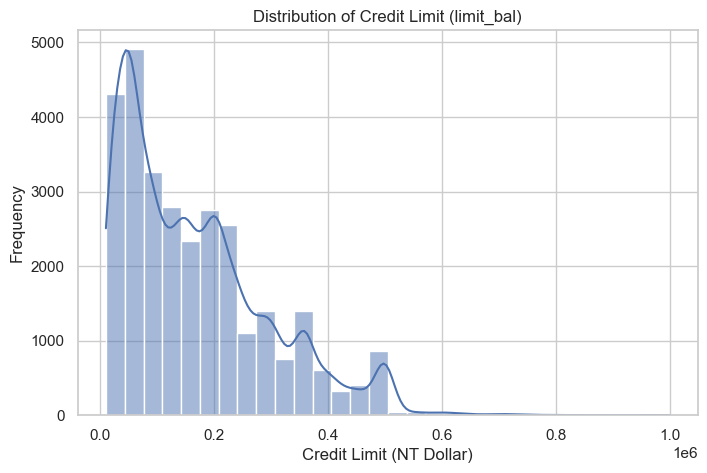

In [2262]:
plt.figure(figsize=(8, 5))
sns.histplot(df['limit_bal'], bins=30, kde=True)
plt.title("Distribution of Credit Limit (limit_bal)")
plt.xlabel("Credit Limit (NT Dollar)")
plt.ylabel("Frequency")
plt.show()


Most clients are concentrated on the lower limits below 200,000 with a few ranging to 800,000

#### Education Level Distribution

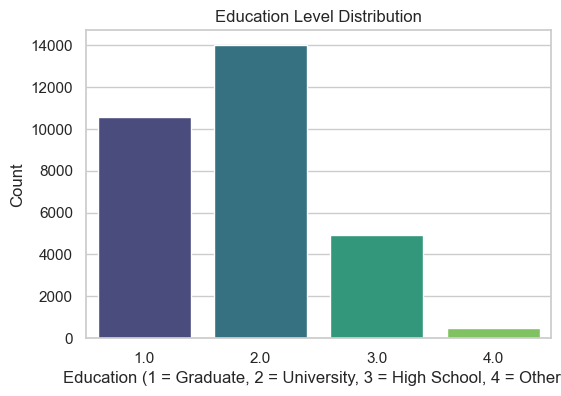

In [2268]:
plt.figure(figsize=(6, 4))
sns.countplot(x='education', data=df, palette='viridis')
plt.title("Education Level Distribution")
plt.xlabel("Education (1 = Graduate, 2 = University, 3 = High School, 4 = Others)")
plt.ylabel("Count")
plt.show()

Most credit card users are university graduates or undergraduates

#### Marital Status Distribution

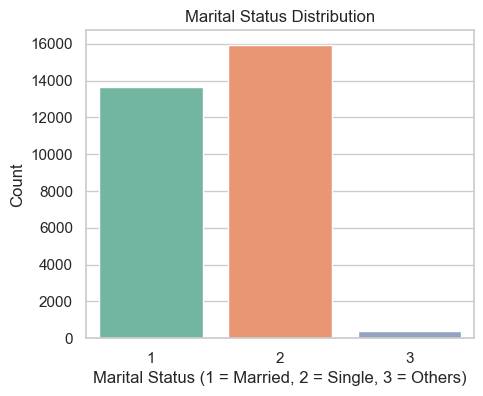

In [2271]:
plt.figure(figsize=(5, 4))
sns.countplot(x='marriage', data=df, palette='Set2')
plt.title("Marital Status Distribution")
plt.xlabel("Marital Status (1 = Married, 2 = Single, 3 = Others)")
plt.ylabel("Count")
plt.show()

#### Age Distribution

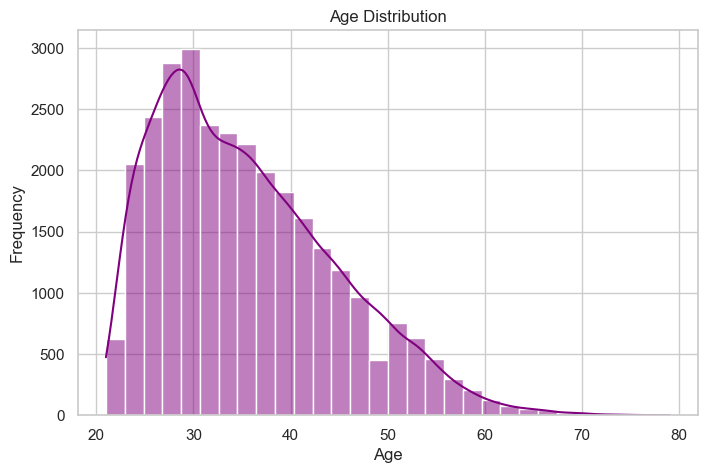

In [2274]:
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=30, kde=True, color="purple")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

A majority of credit card users are young people from ages 20 to 40

#### Distribution of Max Delay

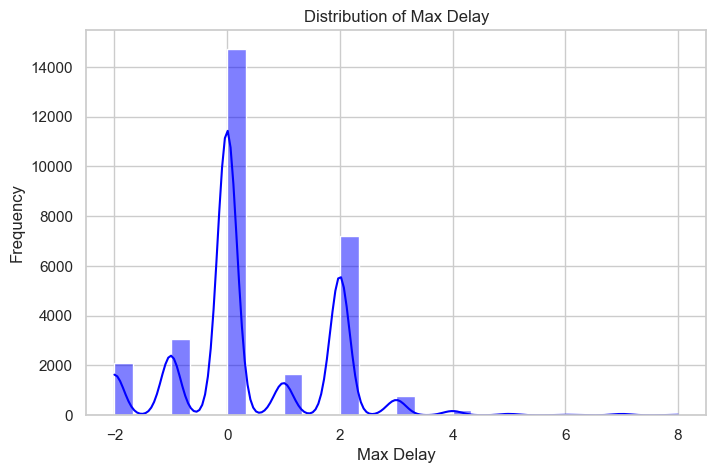

In [2277]:
plt.figure(figsize=(8, 5))
sns.histplot(df['max_delay'], bins=30, kde=True, color="blue")
plt.title("Distribution of Max Delay")
plt.xlabel("Max Delay")
plt.ylabel("Frequency")
plt.show()

Most clients have never had delayed payments

### Bivariate Analysis

#### Correlation for numerical features

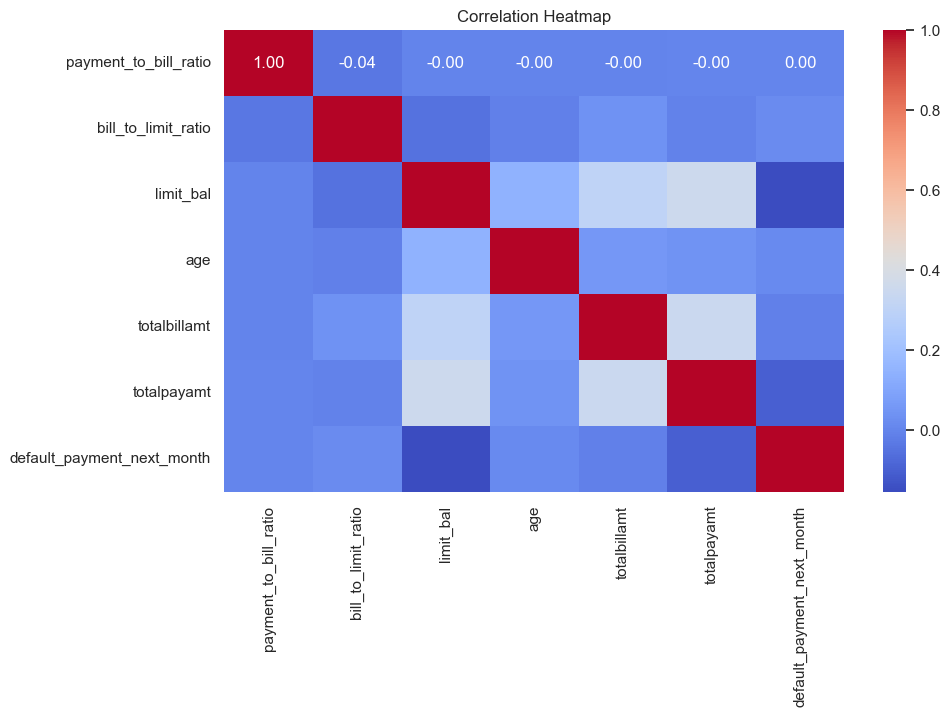

In [2293]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['payment_to_bill_ratio','bill_to_limit_ratio','limit_bal', 'age', 'totalbillamt', 'totalpayamt', 'default_payment_next_month']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### Default Payment by Marriage Category

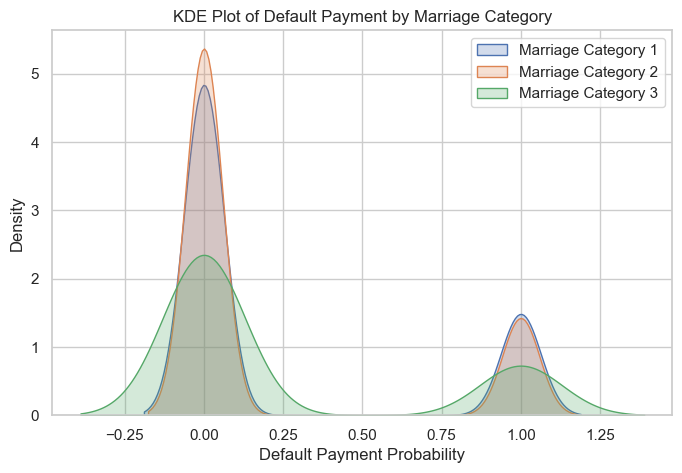

In [2295]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['marriage'] == 1]['default_payment_next_month'], label="Marriage Category 1", fill=True)
sns.kdeplot(df[df['marriage'] == 2]['default_payment_next_month'], label="Marriage Category 2", fill=True)
sns.kdeplot(df[df['marriage'] == 3]['default_payment_next_month'], label="Marriage Category 3", fill=True)

plt.xlabel("Default Payment Probability")
plt.ylabel("Density")
plt.title("KDE Plot of Default Payment by Marriage Category")
plt.legend()
plt.show()

Marriage status seems to play a role, with singles (Category 2) having a slightly lower tendency to default.
However, there is no drastic difference between the three groups, meaning marriage status alone may not be a strong predictor of default behavior.

#### KDE Density Plot for Age vs. Credit Limit

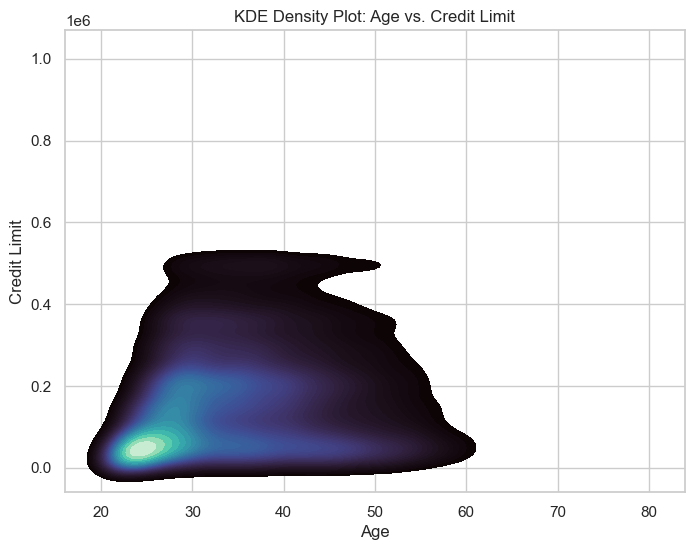

In [2298]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='age', y='limit_bal', fill=True, cmap="mako", levels=50)
plt.title("KDE Density Plot: Age vs. Credit Limit")
plt.xlabel("Age")
plt.ylabel("Credit Limit")
plt.show()

Most individuals are aged 25-40 with credit limits below 200,000.
Older individuals (40-60) have higher credit limits, but this levels off.


#### Credit Limit vs. Default Payment Status

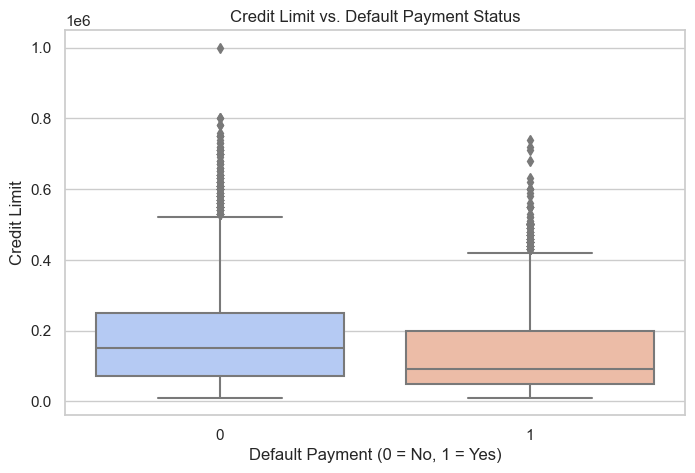

In [2300]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='default_payment_next_month', y='limit_bal', data=df, palette="coolwarm")
plt.title("Credit Limit vs. Default Payment Status")
plt.xlabel("Default Payment (0 = No, 1 = Yes)")
plt.ylabel("Credit Limit")
plt.show()

Both groups show outliers, representing individuals with exceptionally high credit limits. However, there are more extreme high-value outliers in the non-defaulter group, indicating that some individuals with very high credit limits still do not default.

#### Credit Limit Density by Risk Category

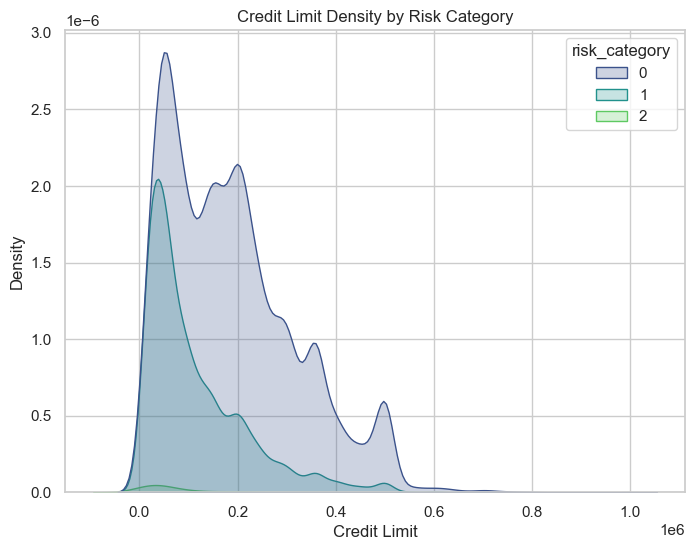

In [2302]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x="limit_bal", hue="risk_category", fill=True, palette="viridis")
plt.title("Credit Limit Density by Risk Category")
plt.xlabel("Credit Limit")
plt.ylabel("Density")
plt.show()

The highest density occurs at low credit limits (close to 0 to ~150,000).Risk category 0 (dark blue) has the highest density at lower credit limits. This indicates that a large proportion of individuals in risk category 0 have low credit limits. Higher credit limits are less frequent but exist across all risk categories

### Multivariate Analysis

#### Max Delay vs. Credit Limit vs. Risk Category

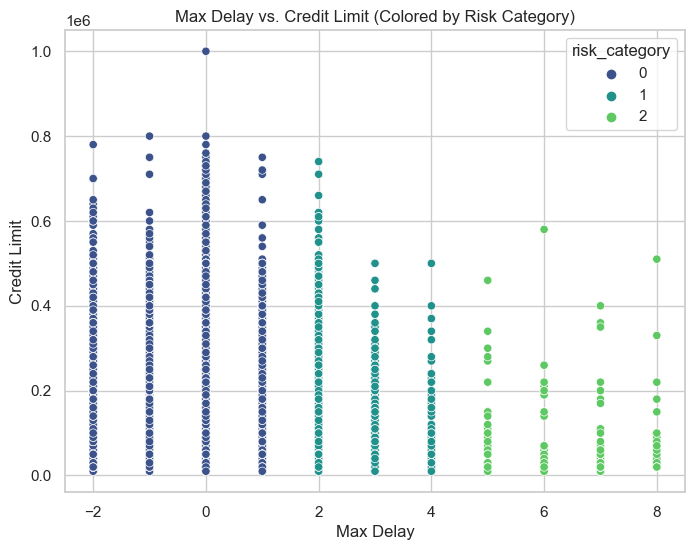

In [2305]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='max_delay', y='limit_bal', hue='risk_category', data=df, palette="viridis")
plt.title("Max Delay vs. Credit Limit (Colored by Risk Category)")
plt.xlabel("Max Delay")
plt.ylabel("Credit Limit")
plt.show()

The majority of customers with high max delays (4 to 8 months late) have lower credit limits. Risk category 0 (blue) dominates among customers with lower delays.
Risk categories 1 and 2 (green shades) are more prominent among those with higher delays.
This suggests that risk category 2 is associated with higher delays. Some customers with high credit limits (600,000+) have max delays of 0 or slightly negative.

#### Credit Limit vs. Total Bill Amount (Colored by Default Status & Gender)

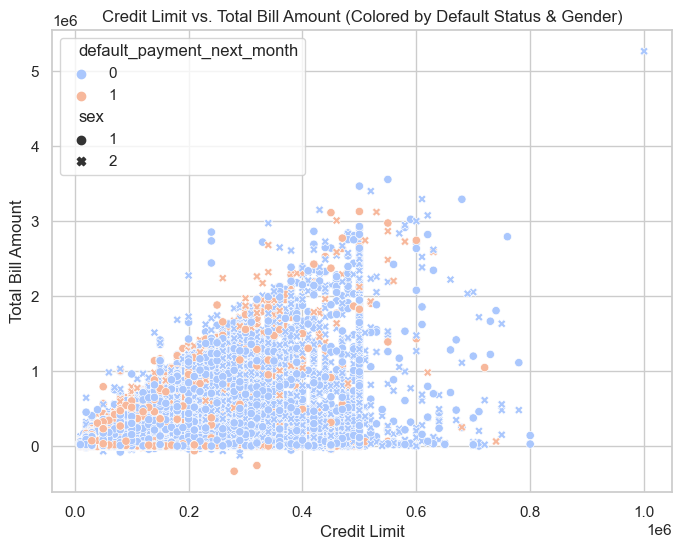

In [2307]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='limit_bal', y='totalbillamt', hue='default_payment_next_month', style='sex', data=df, palette="coolwarm")
plt.title("Credit Limit vs. Total Bill Amount (Colored by Default Status & Gender)")
plt.xlabel("Credit Limit")
plt.ylabel("Total Bill Amount")
plt.show()

As credit limit increases, total bill amount also increases. Most customers (blue) did not default (0).
Defaulters (orange) are present across all credit limits, but they appear more frequently in the mid-range (~100k-400k).
Few defaulters exist at very high credit limits (>600k).

## Preprocessing

In [10]:
df = pd.read_csv("data/cleaned.csv")

In [12]:
df.head()

,limit_bal,sex,education,marriage,age,default_payment_next_month,totalbillamt,totalpayamt,fullrepayment,max_delay,risk_category,bill_to_limit_ratio,payment_to_bill_ratio
0,20000,2,2.0,1,24,1,7704,689,0,2,1,0.385200,0.089434
1,120000,2,2.0,2,26,1,17077,5000,0,2,1,0.142308,0.292791
2,90000,2,2.0,2,34,0,101653,11018,0,0,0,1.129478,0.108388
3,50000,2,2.0,1,37,0,231334,8388,0,0,0,4.626680,0.036259
4,50000,1,2.0,1,57,0,109339,59049,0,0,0,2.186780,0.540054


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_bal                   29965 non-null  int64  
 1   sex                         29965 non-null  int64  
 2   education                   29965 non-null  float64
 3   marriage                    29965 non-null  int64  
 4   age                         29965 non-null  int64  
 5   default_payment_next_month  29965 non-null  int64  
 6   totalbillamt                29965 non-null  int64  
 7   totalpayamt                 29965 non-null  int64  
 8   fullrepayment               29965 non-null  int64  
 9   max_delay                   29965 non-null  int64  
 10  risk_category               29965 non-null  int64  
 11  bill_to_limit_ratio         29965 non-null  float64
 12  payment_to_bill_ratio       29965 non-null  float64
dtypes: float64(3), int64(10)
memory

In [16]:
#Create a copy for LightGBM model since it accepts categorical variables as is
lgb_copy = df.copy()

In [18]:
lgb_copy.head()

,limit_bal,sex,education,marriage,age,default_payment_next_month,totalbillamt,totalpayamt,fullrepayment,max_delay,risk_category,bill_to_limit_ratio,payment_to_bill_ratio
0,20000,2,2.0,1,24,1,7704,689,0,2,1,0.385200,0.089434
1,120000,2,2.0,2,26,1,17077,5000,0,2,1,0.142308,0.292791
2,90000,2,2.0,2,34,0,101653,11018,0,0,0,1.129478,0.108388
3,50000,2,2.0,1,37,0,231334,8388,0,0,0,4.626680,0.036259
4,50000,1,2.0,1,57,0,109339,59049,0,0,0,2.186780,0.540054


### Encoding

In [21]:
# One-hot encoding for nominal categories

In [23]:
df = pd.get_dummies(df, columns=['sex','marriage'], drop_first=True)

In [25]:
# Ordinal encoding for ordered category

In [27]:
education_levels = [[1, 2, 3, 4]]

# Apply ordinal encoding
edu_encoder = OrdinalEncoder(categories=education_levels)
df[['education']] = edu_encoder.fit_transform(df[['education']])+1

In [29]:
risk_categories = [[0,1,2]]
risk_encoder = OrdinalEncoder(categories = risk_categories)
df[['risk_category']] = risk_encoder.fit_transform(df[['risk_category']])

### Split

In [32]:
X = df.drop(columns=['default_payment_next_month'])
y = df['default_payment_next_month']
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Resampling

In [38]:
y_train.value_counts()

default_payment_next_month
0    18662
1     5310
Name: count, dtype: int64

In [40]:
from imblearn.over_sampling import SMOTE

In [42]:
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

In [43]:
y_resampled.value_counts()

default_payment_next_month
0    17994
1    17994
Name: count, dtype: int64

## Modelling

### Logistic regression

In [429]:
X_train_sm = sm.add_constant(X_resampled)
logit_model = sm.Logit(y_resampled, X_train_sm).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.582725
         Iterations 6
                               Logit Regression Results                               
Dep. Variable:     default_payment_next_month   No. Observations:                35988
Model:                                  Logit   Df Residuals:                    35974
Method:                                   MLE   Df Model:                           13
Date:                        Mon, 10 Mar 2025   Pseudo R-squ.:                  0.1593
Time:                                03:21:26   Log-Likelihood:                -20971.
converged:                               True   LL-Null:                       -24945.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2583      0.013    -20.649 

In [436]:
# Make predictions
X_test_const = sm.add_constant(X_test_scaled)
y_pred_probs = logit_model.predict(X_test_const)
y_pred = (y_pred_probs >= 0.5).astype(int) 

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Confusion Matrix:
 [[3648 1025]
 [ 502  818]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      4673
           1       0.44      0.62      0.52      1320

    accuracy                           0.75      5993
   macro avg       0.66      0.70      0.67      5993
weighted avg       0.78      0.75      0.76      5993

Accuracy: 0.7452


#### Tuned model

In [440]:
# Define best parameters found
best_params = {
    'C': 0.17140157450634133,
    'l1_ratio': 0.3948815181755697,
    'max_iter': 500,
    'penalty': 'elasticnet',
    'solver': 'saga'
}

# Train logistic regression model with best parameters
logit_model = LogisticRegression(**best_params)
logit_model.fit(X_resampled, y_resampled)

# Add constant to test set for statsmodels
X_test_const = sm.add_constant(X_test_scaled)

# Predict probabilities and convert to binary based on threshold 0.7
y_pred_probs = logit_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_probs >= 0.45).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Confusion Matrix:
 [[3516 1157]
 [ 468  852]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81      4673
           1       0.42      0.65      0.51      1320

    accuracy                           0.73      5993
   macro avg       0.65      0.70      0.66      5993
weighted avg       0.78      0.73      0.75      5993

Accuracy: 0.7289


Class 1 Recall improved avfter tuning the logistic regression model.

In [359]:
log_reg = LogisticRegression(random_state=42)

# parameter grid for RandomizedSearchCV
param_dist = {
    'C': loguniform(1e-5, 1e5),  # Regularization strength (log scale)
    'penalty': ['l2', 'elasticnet'],  # Type of regularization
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Optimization algorithm
    'max_iter': [100, 200, 300, 500],  # Maximum number of iterations for optimization
    'l1_ratio': uniform(0, 1),  # Ratio of L1 vs. L2 regularization (for 'elasticnet')
}

# Define the RandomizedSearchCV
random_search = RandomizedSearchCV(log_reg, param_distributions=param_dist, 
                                   n_iter=50, scoring='roc_auc', cv=3, 
                                   random_state=42, n_jobs=-1)

# Fit the model with RandomizedSearchCV
random_search.fit(X_resampled, y_resampled)

# Best parameters found
print("Best parameters found: ", random_search.best_params_)

# Get the best model
best_log_reg = random_search.best_estimator_

# Make predictions
X_test_const = sm.add_constant(X_test_scaled)  # Add constant term to test set
y_pred_probs = best_log_reg.predict_proba(X_test_const)[:, 1]  # Probabilities for class 1
y_pred = (y_pred_probs >= 0.6).astype(int)  # Apply threshold of 0.6

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Best parameters found:  {'C': 0.17140157450634133, 'l1_ratio': 0.3948815181755697, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'}


ValueError: X has 14 features, but LogisticRegression is expecting 13 features as input.

### Random Forest Classifier

#### Before tuning parameters

In [200]:
rf_model = RandomForestClassifier()
rf_model.fit(X_resampled, y_resampled)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Performance:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Performance:
[[3926  747]
 [ 658  662]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4673
           1       0.47      0.50      0.49      1320

    accuracy                           0.77      5993
   macro avg       0.66      0.67      0.67      5993
weighted avg       0.77      0.77      0.77      5993



#### After tuning parameters

In [303]:
rf_model = RandomForestClassifier(n_estimators= 5000, min_samples_split= 10, min_samples_leaf= 1, max_depth =10)
rf_model.fit(X_resampled, y_resampled)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Performance:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
[[3679  994]
 [ 505  815]]
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4673
           1       0.45      0.62      0.52      1320

    accuracy                           0.75      5993
   macro avg       0.66      0.70      0.68      5993
weighted avg       0.78      0.75      0.76      5993



Class 1 accuracy and F1 score increased after tuning with parameters:n_estimators= 5000, min_samples_split= 10, min_samples_leaf= 1, max_depth =10.

### XG Boost

#### Base model

In [2632]:
xgb_model = XGBClassifier(random_state=42)

# Train
xgb_model.fit(X_resampled, y_resampled)

# Predictions
y_pred = xgb_model.predict(X_test_scaled)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)
# Evaluate
print("XGBoost Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

XGBoost Model Performance:
Accuracy: 0.7800767562155848
ROC-AUC Score: 0.7406425694998345

Confusion Matrix:
 [[4083  590]
 [ 728  592]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      4673
           1       0.50      0.45      0.47      1320

    accuracy                           0.78      5993
   macro avg       0.67      0.66      0.67      5993
weighted avg       0.77      0.78      0.78      5993



#### Tuned model

In [287]:
# parameters
xgb_model = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=20,
    reg_lambda=1.0,
    reg_alpha=0.1,
    n_estimators=10000,
    max_depth=10,
    learning_rate=0.05,
    gamma=0.3,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_resampled, y_resampled)

# Predictions
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.4).astype(int)

# Evaluate performance
print("XGBoost Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


XGBoost Model Performance:
Accuracy: 0.7046554313365593
ROC-AUC Score: 0.7208985856856603

Confusion Matrix:
 [[3412 1261]
 [ 509  811]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.73      0.79      4673
           1       0.39      0.61      0.48      1320

    accuracy                           0.70      5993
   macro avg       0.63      0.67      0.64      5993
weighted avg       0.76      0.70      0.72      5993



In [227]:
# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500, 1000, 5000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0.0, 0.1, 0.2, 0.3],
    'reg_alpha': [0.01, 0.1, 0.2],
    'reg_lambda': [0.01, 0.1, 0.2, 1.0],
    'scale_pos_weight': [1, 10, 20]
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to test
    scoring='roc_auc',  # We want to maximize ROC-AUC
    cv=5,  # 5-fold cross-validation
    verbose=3,  # Show progress during search
    n_jobs=-1,  # Use all available CPUs
    random_state=42,
    return_train_score=True
)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_resampled, y_resampled)

# Best parameters found by RandomizedSearchCV
print("Best Parameters:", random_search.best_params_)

# Best model after RandomizedSearchCV
best_xgb_model = random_search.best_estimator_

# Train the best model on the entire training data
best_xgb_model.fit(X_resampled, y_resampled, 
                   eval_set=[(X_test_scaled, y_test)], 
                   early_stopping_rounds=50, 
                   verbose=True)

# Predictions
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.4).astype(int)

# Evaluate performance
print("XGBoost Model Performance after RandomizedSearchCV:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 20, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

### K Nearest Neighbour

#### Base model

In [2696]:
knn = KNeighborsClassifier()
knn.fit(X_resampled, y_resampled)

# Predictions
y_pred_knn = knn.predict(X_test_scaled)

# Performance Metrics
print("K-Nearest Neighbors Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))


K-Nearest Neighbors Performance:
Accuracy: 0.6579342566327382
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.75      4673
           1       0.34      0.59      0.43      1320

    accuracy                           0.66      5993
   macro avg       0.60      0.64      0.59      5993
weighted avg       0.74      0.66      0.68      5993



#### Tuned model

In [2700]:
knn = KNeighborsClassifier(n_neighbors=200, metric='euclidean', weights='uniform')

# Train the KNN model
knn.fit(X_resampled, y_resampled)

# Predictions
y_pred_knn = knn.predict(X_test_scaled)

# Performance Metrics
print("K-Nearest Neighbors Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))


K-Nearest Neighbors Performance:
Accuracy: 0.7321875521441682
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.82      4673
           1       0.43      0.64      0.51      1320

    accuracy                           0.73      5993
   macro avg       0.66      0.70      0.66      5993
weighted avg       0.78      0.73      0.75      5993



Class 1 precision, f1-score and recall improved after tuning the model with parameters: n_neighbors=200, metric='euclidean', weights='uniform'

### NLP

#### Base model

In [2623]:
mlp = MLPClassifier()
mlp.fit(X_resampled, y_resampled)

# Predictions
y_pred_mlp = mlp.predict(X_test_scaled)

# Performance Metrics
print("MLP Neural Network Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_mlp))

MLP Neural Network Performance:
Accuracy: 0.7190055064241615
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.81      4673
           1       0.41      0.63      0.50      1320

    accuracy                           0.72      5993
   macro avg       0.64      0.69      0.65      5993
weighted avg       0.77      0.72      0.74      5993

ROC-AUC Score: 0.686910540240842


#### Tuned model

In [2719]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),  # Two hidden layers
                    activation='relu', 
                    solver='adam', 
                    max_iter=300, 
                    random_state=42,
                    )

# Train the Neural Network
mlp.fit(X_resampled, y_resampled)

# Predictions
y_pred_proba = mlp.predict_proba(X_test_scaled)[:, 1]
y_pred_mlp = (y_pred_proba >= 0.3).astype(int)

# Performance Metrics
print("MLP Neural Network Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_mlp))

MLP Neural Network Performance:
Accuracy: 0.7046554313365593
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80      4673
           1       0.38      0.54      0.45      1320

    accuracy                           0.70      5993
   macro avg       0.62      0.65      0.62      5993
weighted avg       0.75      0.70      0.72      5993

ROC-AUC Score: 0.6461810756830015


MLP Classifier performance dropped after tuning the parameters

### LightGBM model

In [82]:
# Load dataset
df1 = lgb_copy
df1.head()

,limit_bal,sex,education,marriage,age,default_payment_next_month,totalbillamt,totalpayamt,fullrepayment,max_delay,risk_category,bill_to_limit_ratio,payment_to_bill_ratio
0,20000,2,2.0,1,24,1,7704,689,0,2,1,0.385200,0.089434
1,120000,2,2.0,2,26,1,17077,5000,0,2,1,0.142308,0.292791
2,90000,2,2.0,2,34,0,101653,11018,0,0,0,1.129478,0.108388
3,50000,2,2.0,1,37,0,231334,8388,0,0,0,4.626680,0.036259
4,50000,1,2.0,1,57,0,109339,59049,0,0,0,2.186780,0.540054


In [84]:
df1 = df1.drop(columns= ['fullrepayment', 'risk_category'], axis =1)
#target = 'default_payment_next_month'

In [64]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_bal                   29965 non-null  int64  
 1   sex                         29965 non-null  int64  
 2   education                   29965 non-null  float64
 3   marriage                    29965 non-null  int64  
 4   age                         29965 non-null  int64  
 5   default_payment_next_month  29965 non-null  int64  
 6   totalbillamt                29965 non-null  int64  
 7   totalpayamt                 29965 non-null  int64  
 8   max_delay                   29965 non-null  int64  
 9   bill_to_limit_ratio         29965 non-null  float64
 10  payment_to_bill_ratio       29965 non-null  float64
dtypes: float64(3), int64(8)
memory usage: 2.5 MB


#### Base model

[LightGBM] [Info] Number of positive: 14567, number of negative: 14567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1354
[LightGBM] [Info] Number of data points in the train set: 29134, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

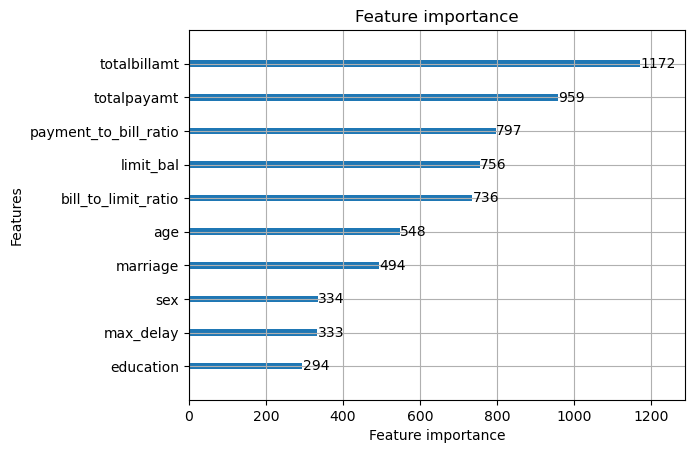

In [67]:
target = 'default_payment_next_month'

# Define categorical features
categorical_features = ['sex', 'education','marriage']

# Convert categorical features to category type
df1[categorical_features] = df1[categorical_features].astype("category")

# Define features and target
X = df1.drop(columns=[target])
y = df1[target]

# Split into Train, Validation, and Test BEFORE Applying SMOTETomek
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Apply SMOTETomek only on Training Set
smotomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smotomek.fit_resample(X_train, y_train.loc[X_train.index])

# Identify numerical features after splitting
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Apply StandardScaler AFTER SMOTETomek
scaler = StandardScaler()
X_train_resampled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features].values)
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features].values)
X_test[numerical_features] = scaler.transform(X_test[numerical_features].values)

# Convert data to LightGBM dataset format
train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Define LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 80,  
    'learning_rate': 0.05,  
    'max_depth': 7,  
    'feature_fraction': 0.8,  
    'bagging_fraction': 0.8,  
    'bagging_freq': 5,  
    'lambda_l1': 1.0,  
    'lambda_l2': 2.0,  
    'min_data_in_leaf': 10,  
    'random_state': 42
}

# Train model with early stopping
lgb_model = lgb.train(
    params, train_data, valid_sets=[valid_data], 
    num_boost_round=1000, callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

# Predictions on test set
y_pred_proba = lgb_model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot feature importance
lgb.plot_importance(lgb_model, max_num_features=10)
plt.show()


#### Tuned model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1353
[LightGBM] [Info] Number of data points in the train set: 33450, number of used features: 10
[LightGBM] [Info] Start training from score 0.500000
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 0.148043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's l2: 0.146382
Early stopping, best iteration is:
[161]	valid_0's l2: 0.146255
Accuracy: 0.736403069736403
ROC-AUC Score: 0.7701430400679489
Classification Report:
               

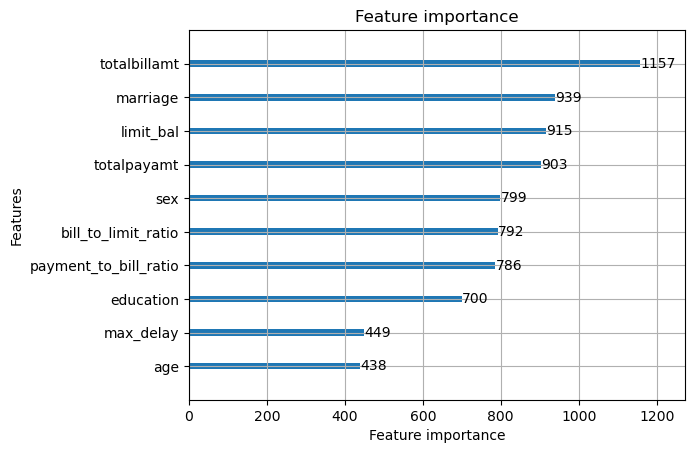

In [307]:
target = 'default_payment_next_month'

#categorical features
categorical_features = ['sex', 'education', 'marriage']
df1[categorical_features] = df1[categorical_features].astype("category")

# Define features and target
X = df1.drop(columns=[target])
y = df1[target]

# Split into Train, Validation, and Test BEFORE Applying SMOTETomek
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=420)#, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)#, stratify=y_temp)

# Apply SMOTETomek only on Training Set
smotomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smotomek.fit_resample(X_train, y_train.loc[X_train.index])

# Identify numerical features after splitting
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Apply StandardScaler AFTER SMOTETomek
scaler = StandardScaler()
X_train_resampled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features].values)
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features].values)
X_test[numerical_features] = scaler.transform(X_test[numerical_features].values)

# Convert data to LightGBM dataset format
train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Define LightGBM parameters
params = {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 50, 'n_estimators': 5000, 'max_depth':7, 'learning_rate': 0.03, 'colsample_bytree': 0.8}

# Train model with early stopping
lgb_model = lgb.train(
    params, train_data, valid_sets=[valid_data], 
    num_boost_round=1000, callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

# Predictions on test set
y_pred_proba = lgb_model.predict(X_test)
y_pred = (y_pred_proba >= 0.3).astype(int)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot feature importance
lgb.plot_importance(lgb_model, max_num_features=10)
plt.show()


Class 1 recall and f1 score improved after tuning the model with parameters: 'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 50, 'n_estimators': 5000, 'max_depth':7, 'learning_rate': 0.03, 'colsample_bytree': 0.8

In [92]:
# parameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'n_estimators': [500, 1000, 5000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.1, 1.0],
    'reg_lambda': [1.0, 10]
}

# Initialize LightGBM model
lgb_model = LGBMClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    lgb_model, param_grid, 
    n_iter=20, scoring='roc_auc', 
    cv=5, random_state=42, n_jobs=-1
)

# Fit the model
random_search.fit(X_resampled, y_resampled)

# Get the best model
best_lgb_model = random_search.best_estimator_

# Predictions on test set
y_pred_proba = best_lgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


[LightGBM] [Info] Number of positive: 17994, number of negative: 17994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2108
[LightGBM] [Info] Number of data points in the train set: 35988, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

ValueError: Found input variables with inconsistent numbers of samples: [4495, 5993]

## Model evaluation

To increase the number of correct predictions, we mostly used a probability value of 0.35 due to the class imbalance in the dataset. Our preferred metric is recall since we would like to retain customers who are at risk of leaving the bank to avoid losing valuable clients. This was however being paired with precision during evaluation to avoid approving credit cards to defaulters. The best performing model was the tuned LightGBM model with an overal accuracy of 73% and ROC-AUC score of 77. It's class 1 precision was 44% while recall was 67% when tuned to the hyperparameters:'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 50, 'n_estimators': 5000, 'max_depth':7, 'learning_rate': 0.03, 'colsample_bytree': 0.8 

## Limitations

1. The dataset was large, hence slow when modelling.
2. The features were not highly statistically significant making prediction hard

## Conclusion and Recommendation

1. Higher credit limits are associated with lower default risk.
2. Lower credit limit individuals are more prone to defaulting.
3. Higher delays are more frequent among low credit limit customers.
4. The majority of defaulters have credit limits below 400k.
5. The best model was a LightGBM model with parameters : 'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 50, 'n_estimators': 5000, 'max_depth':7, 'learning_rate': 0.03, 'colsample_bytree': 0.8 and  an accuracy of 74% and class 1 recall of 67%.